In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers  import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Bidirectional, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from tensorflow.keras.callbacks import EarlyStopping

The four algorithms used for this Assignment:

* Logistic Regression
* LSTM
* LSTM + CNN
* Fastext

#Data Preprocessing steps

In [ ]:
dataset1 = pd.read_excel('Dataset-1.xlsx')
dataset1.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [ ]:
#combining all the texts
dataset1['Texts'] = dataset1['TITLE'] + dataset1['ABSTRACT']
dataset1.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Texts
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps P...
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation i...
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,A finite element approximation for the stochas...
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...


In [ ]:
#Getting the textual Features and labels
texts = dataset1['Texts']
dummy_dataset = dataset1.copy()
dummy_dataset.drop(['ID','TITLE', 'ABSTRACT', 'Texts'], axis = 1, inplace = True)
columns = dummy_dataset.columns.values
labels = dummy_dataset[columns].values

#Preprocessing Pipeline
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', ' ', text)

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
#Apply the pipeline
preprocessed_texts = []
for text in texts:
    preprocessed_text = preprocess_text(text)
    preprocessed_texts.append(preprocessed_text)

In [ ]:
# Function to calculate the vocabulary size
def calculate_vocabulary_size(preprocessed_data):
    vocabulary = set()
    for text in preprocessed_data:
        tokens = text.split()
        vocabulary.update(tokens)
    return len(vocabulary)

vocabulary_size = calculate_vocabulary_size(preprocessed_texts)
print("Vocabulary size:", vocabulary_size)

Vocabulary size: 47488


In [ ]:
#Word embeddings using Word2Vec
from gensim.models import Word2Vec

#Embedding dimension
embed_dim = 100

#Word2Vec model
wordembed_model = Word2Vec(sentences=[text.split() for text in preprocessed_texts], vector_size=embed_dim, window=5, min_count=1, workers=4)

# Access word vectors
word_vectors = wordembed_model.wv

#Logistic Regression

In [ ]:
# function to convert sentences to vector or sentence representations
def sentence_to_vector(sentence, vector_size=embed_dim):
    word_vectors = [wordembed_model.wv[word] for word in sentence if word in wordembed_model.wv]

    if len(word_vectors) == 0:
        return np.zeros(vector_size)

    return np.mean(word_vectors, axis=0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_texts, labels, test_size=0.3, random_state=42)

In [ ]:
# Converting the data into sentence vectors
X_train_word2vec = np.array([sentence_to_vector(text) for text in X_train])
X_test_word2vec = np.array([sentence_to_vector(text) for text in X_test])

In [ ]:
#import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

#Normalising the data
scaler = StandardScaler()
X_train_word2vec = scaler.fit_transform(X_train_word2vec)
X_test_word2vec = scaler.transform(X_test_word2vec)

In [ ]:
# Model training
logistic_reg_model = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=3000))
logistic_reg_model.fit(X_train_word2vec, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=3000))

In [ ]:
#Evaluation
y_pred = logistic_reg_model.predict(X_test_word2vec)
print(classification_report(y_test, y_pred, target_names = columns))

                      precision    recall  f1-score   support

    Computer Science       0.61      0.46      0.52      2535
             Physics       0.56      0.15      0.24      1849
         Mathematics       0.71      0.30      0.43      1711
          Statistics       0.49      0.12      0.19      1554
Quantitative Biology       0.00      0.00      0.00       194
Quantitative Finance       0.00      0.00      0.00        67

           micro avg       0.61      0.27      0.38      7910
           macro avg       0.40      0.17      0.23      7910
        weighted avg       0.58      0.27      0.35      7910
         samples avg       0.31      0.28      0.29      7910



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# LSTM

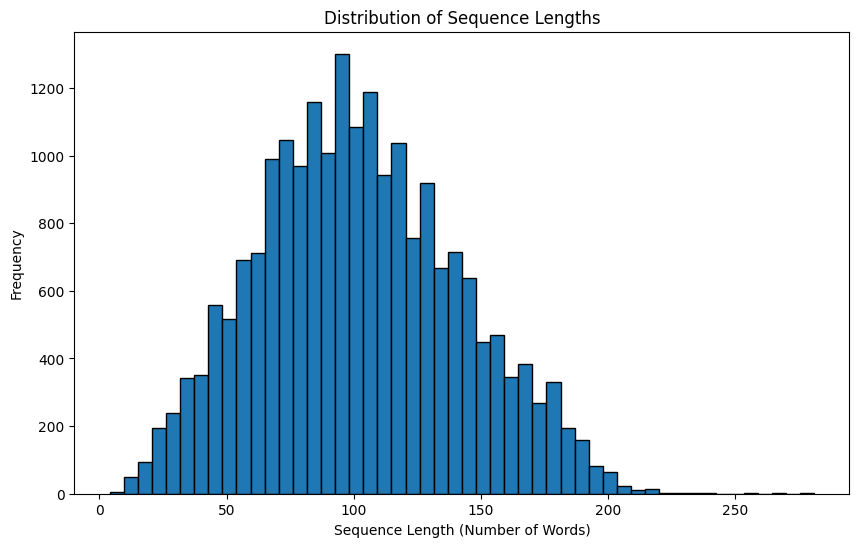

count    20972.000000
mean       101.951554
std         39.514147
min          4.000000
25%         74.000000
50%        100.000000
75%        129.000000
max        281.000000
Name: sequence_length, dtype: float64


In [ ]:
# Analysing the Distribution of lengths of sentences.
import matplotlib.pyplot as plt

data = dataset1.copy()
data['Texts'] = preprocessed_texts
data['sequence_length'] = data['Texts'].apply(lambda x: len(x.split()))

# Plot the distribution of sequence lengths
plt.figure(figsize=(10, 6))
plt.hist(data['sequence_length'], bins=50, edgecolor='black')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()

# Print summary statistics
print(data['sequence_length'].describe())

In [ ]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# Pad sequences to ensure uniform input size
max_sequence_length = 150
X = pad_sequences(sequences, maxlen=max_sequence_length)

#Creating an embedding matrix for the dataset
embedding_matrix = np.zeros((vocabulary_size, embed_dim))

for word, i in word_index.items():
    if word in wordembed_model.wv:
        embedding_matrix[i] = wordembed_model.wv[word]

# Build the LSTM model for multi-label classification
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocabulary_size, output_dim=embed_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
lstm_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(labels.shape[1], activation='sigmoid'))

# Step 5: Compile and train the model
lstm_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.3, random_state=42)

# Train the model
lstm_model.fit(X_train, y_train, validation_split = 0.33, epochs=10, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 174s 532ms/step - accuracy: 0.4703 - auc: 0.7850 - loss: 0.4679 - precision: 0.4609 - recall: 0.5704 - val_accuracy: 0.7606 - val_auc: 0.9298 - val_loss: 0.2573 - val_precision: 0.7879 - val_recall: 0.7000
Epoch 2/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 181s 479ms/step - accuracy: 0.6762 - auc: 0.9079 - loss: 0.2997 - precision: 0.7233 - recall: 0.6443 - val_accuracy: 0.7410 - val_auc: 0.9439 - val_loss: 0.2337 - val_precision: 0.8025 - val_recall: 0.7458
Epoch 3/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 137s 446ms/step - accuracy: 0.7086 - auc: 0.9251 - loss: 0.2718 - precision: 0.7629 - recall: 0.6947 - val_accuracy: 0.7397 - val_auc: 0.9503 - val_loss: 0.2198 - val_precision: 0.8227 - val_recall: 0.7475
Epoch 4/10
308/308 ━━━━━━━━━━━━━━━━━━━━ 146s 460ms/step - accuracy: 0.7216 - auc: 0.9356 - loss: 0.2505 - precision: 0.7865 - recall: 0.7207 - val_accuracy: 0.7370 - val_auc: 0.9514 - val_loss: 0.2180 - val_precision: 0.8059 - val_recall: 0.7643
Epoch 5/10
308/3

In [ ]:
#Evaluation
y_pred = lstm_model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int) # Threshold = 0.5
print(classification_report(y_val, y_pred, target_names = columns))

197/197 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step
                      precision    recall  f1-score   support

    Computer Science       0.78      0.89      0.83      2535
             Physics       0.92      0.81      0.86      1849
         Mathematics       0.88      0.71      0.79      1711
          Statistics       0.76      0.70      0.73      1554
Quantitative Biology       0.00      0.00      0.00       194
Quantitative Finance       0.00      0.00      0.00        67

           micro avg       0.82      0.77      0.80      7910
           macro avg       0.56      0.52      0.53      7910
        weighted avg       0.80      0.77      0.78      7910
         samples avg       0.83      0.80      0.80      7910



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#model summary
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 150, 100)            │       4,748,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,882,356 (18.62 MB)

 Trainable params: 44,518 (173.90 KB)

 Non-trainable params: 4,748,800 (18.12 MB)

 Optimizer params: 89,038 (347.81 KB)

#LSTM + CNN

In [ ]:
#LSTM + CNN model architecture
lstm_cnn = Sequential()
lstm_cnn.add(Embedding(vocabulary_size, embed_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
lstm_cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
lstm_cnn.add(MaxPooling1D(pool_size=2))
lstm_cnn.add(Conv1D(filters=64, kernel_size = 3, activation = 'relu'))
lstm_cnn.add(MaxPooling1D(pool_size=2))
lstm_cnn.add(Bidirectional(LSTM(10)))
lstm_cnn.add(Dense(labels.shape[1], activation='sigmoid'))

# Compile the model
lstm_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Train the model
history = lstm_cnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.33)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


308/308 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5864 - auc_1: 0.8265 - loss: 0.4193 - precision_1: 0.6500 - recall_1: 0.4528 - val_accuracy: 0.7701 - val_auc_1: 0.9249 - val_loss: 0.2684 - val_precision_1: 0.7929 - val_recall_1: 0.6948
Epoch 2/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.7688 - auc_1: 0.9320 - loss: 0.2583 - precision_1: 0.8046 - recall_1: 0.6807 - val_accuracy: 0.7734 - val_auc_1: 0.9364 - val_loss: 0.2413 - val_precision_1: 0.8213 - val_recall_1: 0.7262
Epoch 3/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7565 - auc_1: 0.9385 - loss: 0.2366 - precision_1: 0.8115 - recall_1: 0.7352 - val_accuracy: 0.7678 - val_auc_1: 0.9431 - val_loss: 0.2276 - val_precision_1: 0.8013 - val_recall_1: 0.7782
Epoch 4/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.7546 - auc_1: 0.9505 - loss: 0.2153 - precision_1: 0.8183 - recall_1: 0.7777 - val_accuracy: 0.7571 - val_auc_1: 0.9481 - val_loss: 0.2196 - val_precision_1: 0.8080 - val_recall_

In [ ]:
#Evalutaion
y_pred = lstm_cnn.predict(X_val)
y_pred = (y_pred > 0.5).astype(int) # threshold = 0.5
print(classification_report(y_val, y_pred, target_names = columns))

197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
                      precision    recall  f1-score   support

    Computer Science       0.79      0.84      0.82      2535
             Physics       0.85      0.84      0.84      1849
         Mathematics       0.79      0.77      0.78      1711
          Statistics       0.77      0.59      0.67      1554
Quantitative Biology       0.50      0.12      0.19       194
Quantitative Finance       0.57      0.06      0.11        67

           micro avg       0.80      0.75      0.78      7910
           macro avg       0.71      0.54      0.57      7910
        weighted avg       0.79      0.75      0.77      7910
         samples avg       0.82      0.79      0.78      7910



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Model Summary
lstm_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 150, 100)            │       4,748,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 148, 128)            │          38,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 74, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 72, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 36, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 20)                  │           6,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,956,684 (18.91 MB)

 Trainable params: 69,294 (270.68 KB)

 Non-trainable params: 4,748,800 (18.12 MB)

 Optimizer params: 138,590 (541.37 KB)

# Fastext

In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313472 sha256=aa6784d8a62dffa292bb141d04073e04f9999fc72026aa124cc781c3a4de1c26
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
import fasttext as ft

In [ ]:
# Preprocessing data for fasttext
data = {}

for index, row in dummy_dataset.iterrows():
  label = row[row == 1]
  label = label.index
  labels = ''
  for l in label:
    l = l.replace(" ", '_')
    labels += '__label__' + str(l) + " "

  entity = labels + preprocessed_texts[index]
  data[index] = entity

In [ ]:
data = pd.DataFrame(data.values(), columns=['text'])
data.head()

,text
0,__label__Computer_Science reconstructing subje...
1,__label__Computer_Science rotation invariance ...
2,__label__Mathematics spherical polyharmonics p...
3,__label__Mathematics finite element approximat...
4,__label__Computer_Science __label__Statistics ...


In [ ]:
#train , test split
train, test = train_test_split(data, test_size=0.3, random_state=42)

train.to_csv('train.csv', columns = ['text'], index=False, header=False)
test.to_csv('test.csv', columns = ['text'], index=False, header=False)

In [ ]:
#Training the model
fasttext_model = ft.train_supervised(input = 'train.csv', epoch = 45, lr = 0.1, wordNgrams = 5,bucket = 200000, dim = 100 ,loss = 'ova')

In [ ]:
#Top-1 Evaluation  Results. Output format : (# of test samples, Precision, Recall)
fasttext_model.test('test.csv', k = 1)

(6292, 0.8653846153846154, 0.6883691529709229)

In [ ]:
#Top-2 Evaluation
fasttext_model.test('test.csv',k = 2)

(6292, 0.5688175460902734, 0.9049304677623262)